Загрузите тексты писателей по ссылке:

https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip

Создайте обучающую, проверочную выборки.

Проведите серию экспериментов с различными подходами:

BoW
Embedding
LSTM
Conv1D
Сделайте вывод, какой подход дает максимально лучший результат

# Импорт библиотек

In [ ]:
from google.colab import files, drive
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import time
%matplotlib inline
 
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
 
from sklearn.model_selection import train_test_split
 
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подключение к Гугл диску

In [ ]:
# now = time.time()

# drive.mount('/content/drive')
# !rm '/content/illness'
# !unzip -q '/content/drive/MyDrive/Lessons/lesson5/drive-download-20210817T100428Z-001.zip' -d '/content/illness'

# print(f"Время обработки: {round(time.time() - now, 2)}")

In [ ]:
now = time.time()

drive.mount('/content/drive')
!rm '/content/writers'
!unzip "/content/drive/MyDrive/Lessons/lesson5/writers.zip" -d "/content/writers"

print(f"Время обработки: {round(time.time() - now, 2)}с ")

path = "/content/writers/writers/Русские писатели"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
rm: cannot remove '/content/writers': No such file or directory
Archive:  /content/drive/MyDrive/Lessons/lesson5/writers.zip
   creating: /content/writers/writers/
writers/Русские писатели/:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/),
         continuing with "central" filename version
   creating: /content/writers/writers/Русские писатели/
writers/Русские писатели/Беляев.txt:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/╨С╨╡╨╗╤П╨╡╨▓.txt),
         continuing with "central" filename version
  inflating: /content/writers/writers/Русские писатели/Беляев.txt  
writers/Русские писатели/Булгаков.txt:  mismatching "local" filename (writers/╨а╤Г╤Б╤Б╨║╨╕╨╡ ╨┐╨╕╤Б╨░╤В╨╡╨╗╨╕/╨С╤Г╨╗╨│╨░╨║╨╛╨▓.txt),
         continuing with "central" filename version
  inflating: /content/writers/writers/Русские писатели/Булгаков.tx

# Вспомогательные функции

In [ ]:
def readText(fileName):
  file = open(fileName, 'r')
  text = file.read()
  text = text.split('\n')
  text_one, text_two = train_test_split(text, test_size=0.2, shuffle=True)
  
  return [" ".join(text_one), " ".join(text_two)]

In [ ]:
def getSet(wordIndex, xLen, step):
  sample = []
  wordLen = len(wordIndex)
  index = 0

  while (index + xLen <= wordLen):
    sample.append(wordIndex[index:index + xLen])
    index += step
  
  return sample

In [ ]:
def getBigSet(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  classesXSamples = []
  for wI in wordIndexes:
    classesXSamples.append(getSet(wI, xLen, step))

  xSamples = []
  ySamples = []

  
  for ii in range(nClasses):

    yy = utils.to_categorical(ii, nClasses)
    for elem in classesXSamples[ii]:

      ySamples.append(yy)
      xSamples.append(elem)


  return (np.array(xSamples), np.array(ySamples))

In [ ]:
xLen, step = 1000, 100

In [ ]:
def multiTest(model, xTest, yTest, name, className):
  print("НЕЙРОНКА: ", name)
  print('-'*20)
  
  totalSumRec = 0

  nClasses = len(className)

  currPred = model.predict(xTest)
  currOut = np.argmax(currPred, axis=1)

  trueOut = np.argmax(yTest, axis=1)

  val = 0

  for ii in range(len(currOut)):
    print(f"Правильнаый ответ: {trueOut}, модель выбрала: {currOut}")
    if currOut[ii] == trueOut[ii]:
      print("ПРАВИЛЬНО\n")
      val += 1
    else:
      print("НЕПРАВИЛЬНО\n")

  return val/len(yTest)

In [ ]:
def showPicture(history, loss=True, accuracy=True):
  
  if loss:
    plt.figure(figsize = (14, 7))
    plt.plot(history.history['loss'], 
            label='Значение ошибки на обучающем наборе')
    plt.plot(history.history['val_loss'], 
            label='Значение ошибки на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Значение ошибки')
    plt.legend()
    plt.show()
  
  if accuracy:
    plt.figure(figsize = (14, 7))
    plt.plot(history.history['accuracy'], 
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'], 
            label='Доля верных ответов на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    plt.show()

In [ ]:
def create_model(xLen=50):
  model = Sequential()
  model.add(Dense(100, activation="relu", input_shape=(xLen,)))
  model.add(Dense(100, activation="relu"))
  model.add(Dense(10, activation="softmax"))

  model.compile(optimizer=Adam(lr=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

  model.summary()

  return model

# Функция создания модели

In [ ]:
def createModel(maxWordsCount=20000, xLen=1000, level=1, emb=True):
  model = Sequential()
  # model.add(Dense(16, activation="relu", input_shape=(xLen,)))
  model.add(Input(shape=(xLen, 1)))
  model.add(BatchNormalization())

  if level not in [1, 2, 3]:
    level = 1

  if level == 1:
    model.add(Embedding(maxWordsCount, 5, input_length=xLen))
    model.add(SpatialDropout1D(0.2))
    model.add(BatchNormalization())

  elif level == 2:
    model.add(LSTM(4))
  
  elif level == 3:
    model.add(Conv1D(20, 5, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())

  # if emb:

  
  else:
    model.add(Dense(32, input_dim=xLen, activation="relu"))


  # if level not in [1, 2, 3, 4, 5]:
  #   level = 1

  # if level == 6:
  #   model.add(SimpleRNN(4))
  #   model.add(Dropout(0.2))
  #   model.add(Dense(100, activation='relu'))

  # if level == 7:
  #   model.add(LSTM(4))

  # if level == 8: 
  #   model.add(Conv1D(20, 5, activation='relu', padding='same'))
  #   model.add(MaxPooling1D(2))
  #   model.add(Dropout(0.2))
  #   model.add(BatchNormalization())
  #   model.add(Flatten())

  # if level == 9:
  #   model.add(LSTM(4, return_sequences=1))
  #   model.add(Dense(100, activation='relu'))
  #   model.add(Conv1D(20, 5, activation='relu'))
  #   model.add(MaxPooling1D(2))
  #   model.add(Dropout(0.2))
  #   model.add(BatchNormalization())
  #   model.add(Flatten())
  
  # if level == 5:
  #   model.add(Dense(8, activation="relu"))

  model.add(Flatten())
  model.add(Dense(20, activation="softmax"))

  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  model.summary()

  return model

# Подготовка данных

In [ ]:
filesNames = os.listdir(path)

In [ ]:
classes = [name.split('.')[0] for name in filesNames]
yTotal = list()
xTrain, xTest = list(), list()

In [ ]:
for name in filesNames:
  yTotal.append(name.split('.')[0])
  text = readText(f"{path}/{name}")
  xTrain.append(text[0])
  xTest.append(text[1])

In [ ]:
print(len(xTrain[0]))
print(len(xTest[0]))
print(len(yTotal))

2719353
666913
20


#Константы

In [ ]:
xLen, step = 1000, 100
maxWordsCount = 20000
epochs = 50

In [ ]:
tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff',
                      lower=True,
                      char_level=False,
                      oov_token="noName",
                      split=' ')

tokenizer.fit_on_texts(xTrain)
train_index = tokenizer.texts_to_sequences(xTrain)
test_index = tokenizer.texts_to_sequences(xTest)

xTrain, yTrain = getBigSet(train_index, xLen, step)
xTest, yTest = getBigSet(test_index, xLen, step)

xTrain = xTrain.reshape(xTrain.shape + (1,))
xTest = xTest.reshape(xTest.shape + (1,))

In [ ]:
print(xTrain.shape)

(69272, 1000, 1)


In [ ]:
print(xTrain.shape)

(69272, 1000, 1)


In [ ]:
# print(xTrain.shape)
# xTrainBoW = tokenizer.sequences_to_matrix(xTrain.tolist())
# print(xTrainBoW[10])

# Эксперимент 1: модель с использованием Embedding

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 5)           100000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 5)          0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 1000, 5)          20        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 20)                100020    
                                                                 
Total params: 200,040
Trainable params: 200,030
Non-trai

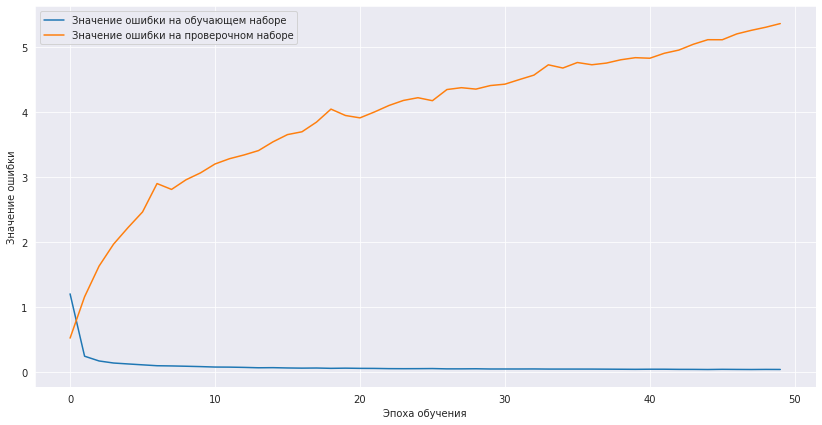

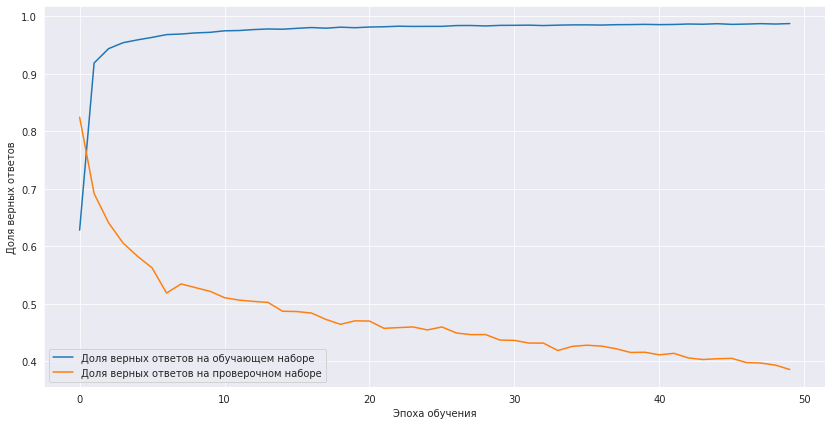

Streaming output truncated to the last 5000 lines.

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
ПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
ПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
ПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
ПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
ПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
ПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
ПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11  4  7 ...  5  5 15]
НЕПРА

In [ ]:
model = createModel(level=1)

history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)*100}%")

# Эксперимент 2: модель с применением LSTM слоя

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 1000, 1)          4         
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 4)                 96        
                                                                 
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 20)                100       
                                                                 
Total params: 200
Trainable params: 198
Non-trainable params: 2
_________________________________________________________________
Epoch 1/10
1083/1083 [==============================] - 367s 337ms/step - loss: 2.9136 - accuracy: 0.1219 - val_loss: 2.90

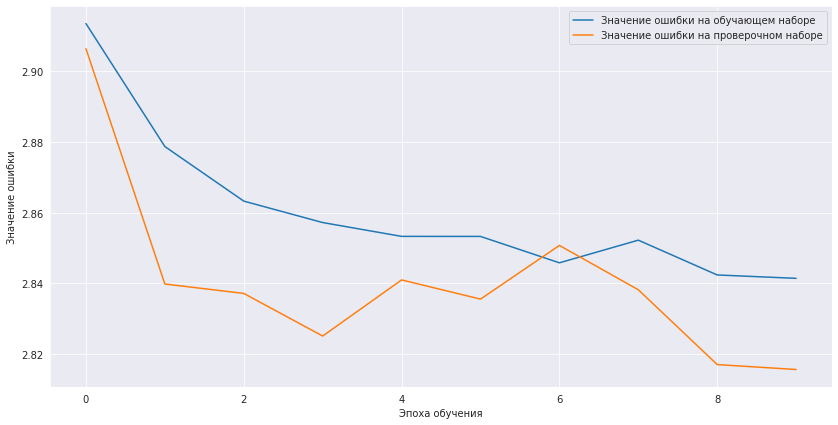

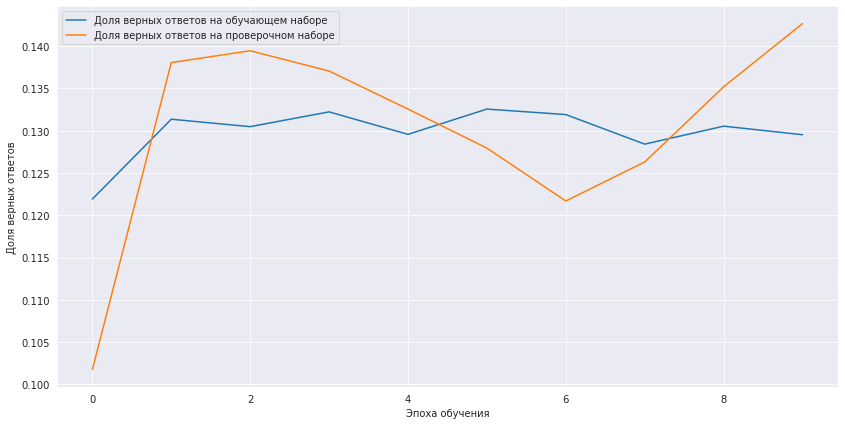

Streaming output truncated to the last 5000 lines.

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [4 4 0 ... 0 4 0]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19

In [ ]:
model = createModel(level=2)

epochs = 10

history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)*100}%")

# Эксперимент 3: модель с применением Conv1D

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 1000, 1)          4         
 hNormalization)                                                 
                                                                 
 conv1d (Conv1D)             (None, 1000, 20)          120       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 20)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 500, 20)           0         
                                                                 
 batch_normalization_4 (Batc  (None, 500, 20)          80        
 hNormalization)                                                 
                                                      

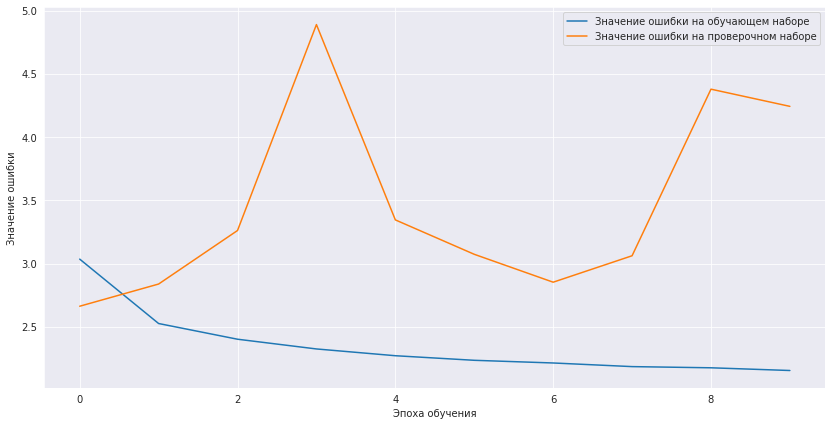

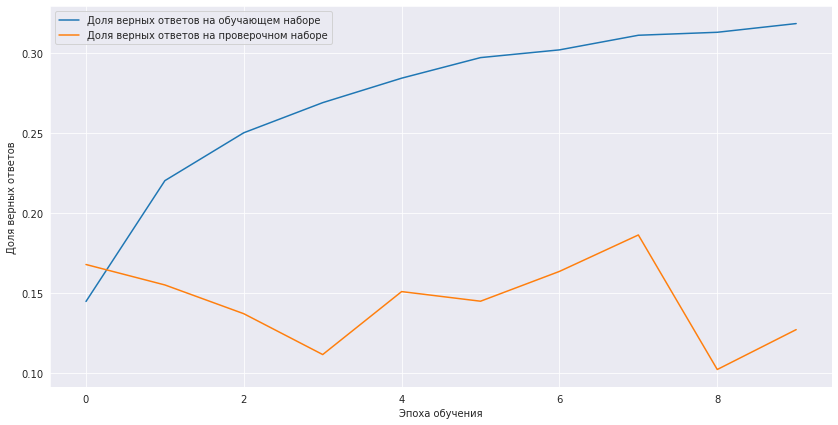

Streaming output truncated to the last 5000 lines.

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 19 11 11]
НЕПРАВИЛЬНО

Правильнаый ответ: [ 0  0  0 ... 19 19 19], модель выбрала: [11 11 11 ... 1

In [ ]:
model = createModel(level=3)

epochs = 10

history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)

showPicture(history)

currOut = multiTest(model, xTest, yTest, "test", yTotal)
print(f"Процент точности модели: {round(currOut, 2)*100}%")

# Эксперимент 4: модель с применением Bag of Words

In [ ]:
model = Sequential()
model.add(Dense(200, input_dim=xLen, activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(20, activation="sigmoid"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(xTrain,
                    yTrain,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(xTest, yTest),
                    verbose=1)


Epoch 1/10
1083/1083 [==============================] - 6s 5ms/step - loss: 2.9618 - accuracy: 0.1262 - val_loss: 2.7066 - val_accuracy: 0.1792
Epoch 2/10
1083/1083 [==============================] - 5s 5ms/step - loss: 2.7033 - accuracy: 0.1693 - val_loss: 2.6768 - val_accuracy: 0.1812
Epoch 3/10
1083/1083 [==============================] - 5s 5ms/step - loss: 2.6812 - accuracy: 0.1753 - val_loss: 2.6786 - val_accuracy: 0.1789
Epoch 4/10
1083/1083 [==============================] - 5s 5ms/step - loss: 2.6613 - accuracy: 0.1795 - val_loss: 2.6993 - val_accuracy: 0.1813
Epoch 5/10
1083/1083 [==============================] - 5s 5ms/step - loss: 2.6385 - accuracy: 0.1841 - val_loss: 2.7087 - val_accuracy: 0.1741
Epoch 6/10
1083/1083 [==============================] - 5s 5ms/step - loss: 2.6198 - accuracy: 0.1890 - val_loss: 2.7155 - val_accuracy: 0.1736
Epoch 7/10
1083/1083 [==============================] - 5s 5ms/step - loss: 2.5989 - accuracy: 0.1934 - val_loss: 2.7378 - val_accuracy:

# ВЫВОД

Из проведенных экспериментов можно сделать вывод, что лучше всего работает модель с использованием Embedding, но также эта модель обучалась не очень долго
Остальные модели показали результаты хуже, но при этом модель с применением LSTM слоя еще и затратила очень много времени на обучение